#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[-0.07181236,  0.85193066,  0.51870718],
       [-0.21629136,  0.49437398, -0.84190998],
       [-0.97368426, -0.17265142,  0.14876308]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001855


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000217


In [37]:
C1(dx,dy,dz,Ret)

array([[-5.02743504e-01,  8.51725852e-02,  7.89611225e+00,
         2.50915386e-01,  5.62850671e-03,  3.37914901e-02,
        -1.13288998e+00, -2.07604695e+00, -5.34783629e-01,
        -1.34248361e-01, -8.36432355e-01,  4.14905553e-01,
        -8.87820258e-01, -1.00190384e+00, -1.39027358e+00,
         2.41114317e+00,  1.59957268e+00,  3.41430410e+00,
        -1.16695106e-01, -5.41425884e-01,  2.76826806e+00,
        -3.22281361e+00,  5.00580730e-01, -7.71620615e-01,
         1.16665663e-01,  6.51879436e-01, -5.50791463e-02,
         4.17680929e-01,  1.88362813e+00,  2.45701224e+00,
         3.83859401e+00, -2.24915549e+00,  2.47484743e+00,
        -5.75592442e-01,  1.76068376e+00,  9.96437601e-02,
         6.36111833e+00,  1.36763142e+00, -6.21805361e-03,
         5.53072639e-01,  8.31689146e-02,  2.29575081e-04,
         1.56458163e-01, -2.95578520e-02, -2.65197136e-03,
        -6.30935937e-01, -1.46382502e-01, -7.14252085e-01,
        -6.80555923e-01, -3.07862991e+00],
       [-3.25

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-2.88526203e+03, -1.86628671e+04,  9.91386929e+03],
       [ 4.88808357e+02, -1.02626574e+04, -2.79505072e+03],
       [ 4.53160562e+04,  1.55763414e+03, -1.24523099e+03],
       [ 1.44001191e+03, -1.10941621e+02,  6.28084191e+02],
       [ 3.23021910e+01,  3.67586336e+03, -5.79273140e+03],
       [ 1.93930508e+02, -2.44603273e+03,  2.19913305e+04],
       [-6.50169407e+03, -1.09384152e+01, -1.50101492e+03],
       [-1.19145039e+04, -7.43132987e+03, -2.82184034e+03],
       [-3.06914140e+03,  2.37694501e+03,  8.43707105e+03],
       [-7.70455901e+02,  7.55710329e+02, -4.16574794e+02],
       [-4.80031367e+03,  6.05636683e+02, -1.47047403e+02],
       [ 2.38115705e+03,  4.55758199e+03,  2.70351293e+03],
       [-5.09523059e+03,  7.73670841e+03, -9.06973766e+03],
       [-5.74996015e+03,  2.76061541e+03, -2.77130285e+03],
       [-7.97882727e+03,  8.74119340e+02,  2.09905604e+02],
       [ 1.38376325e+04,  1.13477254e+04, -9.48833050e+03],
       [ 9.18000189e+03,  4.60554389e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000109


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000320


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000027


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 0.26698877, -2.10937136, -0.91533414],
       [-0.56099783,  0.53565956,  0.50938857],
       [ 1.28285491, -1.0902475 ,  0.7767876 ],
       [ 0.22621142,  0.26834806,  0.30527551],
       [ 0.50407603, -0.43334835, -0.88466516],
       [ 0.22330133,  0.22292328, -0.24073429],
       [-1.17359181, -0.50341048,  0.74463588],
       [ 1.09905076,  0.02577413,  0.01517687],
       [ 0.35482521,  0.18418713,  0.87694004],
       [ 0.63979205,  1.81539804,  0.32151928],
       [-1.51244036,  1.26003647, -0.33994463],
       [ 0.60030744,  0.08360856,  1.19888995],
       [-1.47030086,  0.38043192, -0.89082567],
       [ 0.00338065,  0.51762794,  0.60970431],
       [-0.58958183, -0.69845362,  0.81297078],
       [-0.24618632, -0.08147997, -0.08749228],
       [-1.84402787, -0.54514926,  0.13827576],
       [-0.23131014, -0.83893426, -2.19422196],
       [ 1.36005145, -0.49008245, -2.28579988],
       [ 0.60280024,  1.22736189, -1.09221504],
       [-0.85969544,  1.10224286, -0.199

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000210


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000509


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000602


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 6.96694863e-02, -1.37132401e+00,  1.70464513e+00],
       [ 6.19836613e-02,  1.63871338e+00, -1.02338248e+00],
       [ 3.31360733e-01, -6.50103021e-01,  9.39064390e-01],
       [-4.39369120e-01, -4.05324818e-01,  6.31436566e-01],
       [ 5.07882464e-01, -7.21588129e-01,  5.83253327e-01],
       [ 1.11667316e+00,  7.41649673e-01, -5.56533167e-01],
       [ 6.94281151e-01, -1.55246711e-01,  4.64046193e-01],
       [-1.71978423e-01,  7.26673545e-01, -1.50095980e+00],
       [-1.06763012e+00, -2.81743549e-01, -8.62020750e-02],
       [ 2.72086514e-01,  1.56234029e+00, -2.74146399e-01],
       [-1.75854103e+00, -1.92107557e+00,  4.82736975e-01],
       [-6.87449855e-01, -1.55440298e+00,  7.51810141e-01],
       [ 9.66865940e-01,  4.40582592e-01, -5.67942860e-01],
       [-5.17804865e-01, -2.22664640e+00, -1.22872160e+00],
       [-3.74641168e-03,  1.27429744e+00, -1.43261109e-01],
       [-1.06929018e+00, -1.93766385e-01,  1.95744200e-02],
       [ 1.98901462e+00,  6.55915371e-01

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.06384152e-02, -2.08572143e-04,  1.67496187e-02,
         3.46390825e-04, -4.08518277e-03, -4.16207504e-03,
         1.12082660e-02, -9.40500422e-05,  6.24552730e-03,
        -1.33528061e-02, -1.43368410e-02,  1.00437468e-02,
        -1.14236136e-02,  8.55811742e-04,  1.35689444e-02,
        -5.83663604e-05,  6.12355868e-03, -1.22435596e-02,
        -1.61899840e-02, -2.08161047e-02, -1.16632989e-02,
        -3.39202811e-03,  3.85418805e-03, -7.11345339e-03,
         1.32852098e-02, -1.92999806e-02,  1.55607119e-03,
         9.12413634e-03,  6.35992960e-03, -5.51962726e-03,
        -1.34924104e-02, -2.23208293e-03, -1.67536167e-03,
        -1.93704032e-03, -1.03759913e-02,  1.04836736e-02,
         1.98320920e-02, -4.89080355e-03,  9.30340745e-03,
         1.77128455e-02, -1.75944002e-03, -2.04144219e-04,
         8.09388277e-03,  2.54975931e-02, -1.17429671e-02,
         1.72206583e-02, -4.32593179e-03,  2.05061558e-03,
        -1.25763999e-02, -1.57736418e-02],
       [ 9.40

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000919


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-2.78014384e-06,  8.15225017e-07,  1.23853142e-06,
        -1.46321172e-07, -1.37303849e-06, -3.37080872e-07,
         8.06442628e-07, -1.06817689e-06, -6.28452024e-07,
        -2.59887704e-06,  6.55440054e-07, -3.32879223e-07,
        -3.33199001e-07, -1.86987068e-07,  1.99262755e-06,
        -2.37008515e-08, -1.08848069e-06,  2.69283428e-06,
         4.26549171e-06,  3.15802214e-07, -2.23105802e-06,
        -8.65987975e-09, -1.97082169e-07,  4.40940030e-08,
         7.32715448e-07, -2.24025323e-06, -1.42328124e-06,
         3.55469363e-06, -1.27846397e-07,  1.41190980e-07,
        -1.11071253e-06,  1.14841394e-06, -1.87253400e-06,
        -6.37475999e-08,  3.99945998e-07,  1.60257439e-07,
         2.42544565e-06, -2.55530754e-06, -5.69644417e-07,
         2.66147197e-06, -5.87480070e-07,  1.77512751e-06,
         9.20273263e-07,  3.10358331e-06,  1.51334732e-06,
         2.80887199e-06, -8.35151003e-07,  7.79653665e-07,
        -1.26694994e-06, -4.58765587e-07],
       [ 1.83

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.88526203e+03, -4.88808357e+02, -4.53160562e+04,
        -1.44001191e+03, -3.23021910e+01, -1.93930508e+02,
         6.50169407e+03,  1.19145039e+04,  3.06914140e+03,
         7.70455901e+02,  4.80031367e+03, -2.38115705e+03,
         5.09523059e+03,  5.74996015e+03,  7.97882727e+03,
        -1.38376325e+04, -9.18000189e+03, -1.95948071e+04,
         6.69717173e+02,  3.10726152e+03, -1.58871844e+04,
         1.84958367e+04, -2.87284980e+03,  4.42835690e+03,
        -6.69548199e+02, -3.74115821e+03,  3.16101090e+02,
        -2.39708502e+03, -1.08102057e+04, -1.41008766e+04,
        -2.20298213e+04,  1.29079797e+04, -1.42032334e+04,
         3.30334456e+03, -1.01046238e+04, -5.71858921e+02,
        -3.65066740e+04, -7.84888311e+03,  3.56856207e+01,
        -3.17410265e+03, -4.77309223e+02, -1.31753918e+00,
        -8.97918705e+02,  1.69633516e+02,  1.52197536e+01,
         3.62096275e+03,  8.40094147e+02,  4.09911695e+03,
         3.90573354e+03,  1.76683616e+04],
       [ 1.86

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001218


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-1.92900269e+02,  2.58634179e+06, -6.37886870e+05],
       [-2.96489919e+01, -2.16665935e+05,  5.16176808e+05],
       [-1.96414168e+02,  3.74716197e+06, -1.76327017e+06],
       [ 1.44524667e+02,  2.10248009e+06, -3.56250549e+06],
       [-1.55356457e+02,  2.91362482e+06, -1.34443607e+06],
       [ 2.30526047e+02, -2.41336094e+06,  8.48197004e+04],
       [ 1.04807068e+02,  1.19726484e+06, -2.25603623e+06],
       [ 1.14232442e-01, -1.00226921e+03, -1.51601332e+02],
       [-1.16367687e+02,  6.95411728e+05,  4.80043585e+05],
       [ 2.48415876e+02, -4.12079275e+04, -2.46816799e+06],
       [-3.55807287e+01,  3.72935496e+05, -1.35349425e+04],
       [ 9.79037603e+01,  8.60768740e+05, -1.84978918e+06],
       [ 6.76609123e+01, -5.57871362e+05, -1.25578445e+05],
       [-3.82331423e+01,  3.85964459e+05,  2.28844126e+02],
       [ 4.49710298e+01, -8.27973807e+05,  3.73739996e+05],
       [-1.21342133e+02,  5.77305359e+05,  6.48405407e+05],
       [ 1.32520120e+02, -1.06702661e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 1.14801362e+08, -6.37773217e+07, -2.58622814e+08],
       [ 3.70337300e+05,  5.16177174e+07,  2.16666302e+07],
       [-1.06785936e+08, -1.76337589e+08, -3.74726769e+08],
       [-3.00867841e+08, -3.56280335e+08, -2.10277793e+08],
       [-3.65642502e+08, -1.34479806e+08, -2.91398679e+08],
       [-7.16442017e+07,  8.47487726e+06,  2.41329001e+08],
       [-5.31253804e+08, -2.25656217e+08, -1.19779075e+08],
       [-4.16956790e+08, -5.64388623e+04,  5.89502832e+04],
       [-7.92386814e+08,  4.79259122e+07, -6.96196151e+07],
       [-1.06210309e+03, -2.46816799e+08,  4.12079264e+06],
       [ 5.63862139e+07, -1.34791201e+06, -3.72879677e+07],
       [ 8.20211411e+05, -1.84978837e+08, -8.60767928e+07],
       [-7.33724002e+08, -1.26304832e+07,  5.57145012e+07],
       [ 2.57974939e+08,  4.84239359e+04, -3.85709077e+07],
       [-2.48602129e+07,  3.73715385e+07,  8.27949197e+07],
       [-6.70789901e+08,  6.47741325e+07, -5.77969407e+07],
       [-4.08556495e+08, -2.71978475e+07

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000453


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001163


In [82]:
d_me_

array([[ 5.37060140e-02, -3.90285127e+02, -1.52207484e+02],
       [-2.17840942e-02, -1.68028551e+01,  2.36856175e+02],
       [ 4.98929817e-02, -5.17394572e+02,  1.34258255e+01],
       [ 2.59959236e-02, -3.26693174e+02,  6.41113794e+01],
       [-3.40377881e-03,  5.74936016e+01, -2.31131745e+01],
       [ 3.44725662e-02, -1.90760997e+02, -1.57454663e+02],
       [ 2.70012482e-02, -1.67302657e+01, -2.56022543e+02],
       [-9.83011768e-05,  5.52422590e+02, -5.51457593e+02],
       [ 5.71074506e-03,  5.98803706e+02, -6.56521258e+02],
       [-8.33513020e-02, -4.07468237e+00,  8.46049756e+02],
       [ 3.37167159e-03,  1.04189052e+02, -1.38253340e+02],
       [-9.17996248e-03, -1.29517696e+02,  2.22255836e+02],
       [-5.38678886e-03,  6.76666909e+02, -6.22286443e+02],
       [ 5.45687013e-03,  3.45905914e+02, -4.01046127e+02],
       [-8.74472580e-02, -2.10203609e+00,  8.85452392e+02],
       [ 1.08928082e-02,  4.99845403e+02, -6.09904656e+02],
       [ 8.68707586e-03,  3.67539679e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.88526203e+03, -4.88808357e+02, -4.53160562e+04,
        -1.44001191e+03, -3.23021910e+01, -1.93930508e+02,
         6.50169407e+03,  1.19145039e+04,  3.06914140e+03,
         7.70455901e+02,  4.80031367e+03, -2.38115705e+03,
         5.09523059e+03,  5.74996015e+03,  7.97882727e+03,
        -1.38376325e+04, -9.18000189e+03, -1.95948071e+04,
         6.69717173e+02,  3.10726152e+03, -1.58871844e+04,
         1.84958367e+04, -2.87284980e+03,  4.42835690e+03,
        -6.69548199e+02, -3.74115821e+03,  3.16101090e+02,
        -2.39708502e+03, -1.08102057e+04, -1.41008766e+04,
        -2.20298213e+04,  1.29079797e+04, -1.42032334e+04,
         3.30334456e+03, -1.01046238e+04, -5.71858921e+02,
        -3.65066740e+04, -7.84888311e+03,  3.56856207e+01,
        -3.17410265e+03, -4.77309223e+02, -1.31753918e+00,
        -8.97918705e+02,  1.69633516e+02,  1.52197536e+01,
         3.62096275e+03,  8.40094147e+02,  4.09911695e+03,
         3.90573354e+03,  1.76683616e+04],
       [ 1.86

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

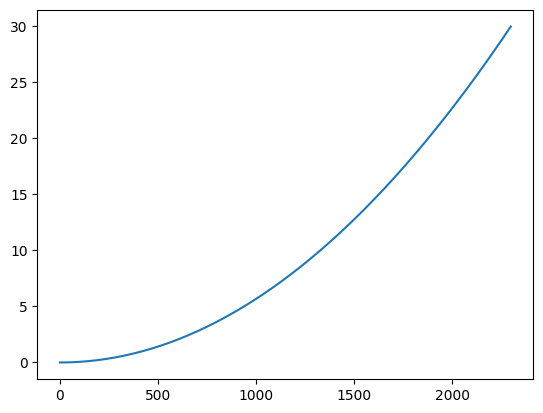

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_28056/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

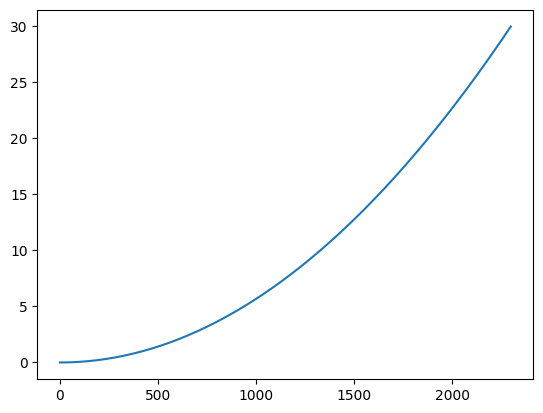

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
#     print(K)  

      


    glob_force = fsolve(lambda x: np.linalg.inv(K)@x - np.array(vessel_movement) , np.zeros(len(vessel_movement)))
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6)

    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

#     f=ku 
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [1, 2],
                      [2, 3]]),
        bc_node=list(range(6)),
        bc_val=[0]*6,
        vessel_movement=[
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                        -0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4],
        coefs=[1,1,1,1,1,1])

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_28056/2732499989.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: np.linalg.inv(K)@x - np.array(vessel_movement) , np.zeros(len(vessel_movement)))


In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4

(-7.05e-06, -7e-08, 1.418e-05)

In [114]:
# f=k*d
# k^-1*f=d

In [115]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.33853599e-12,  6.58142213e-10,
        5.84828243e-10,  8.28260564e-11, -1.16907934e-10,  3.40885374e-10,
       -1.81169822e-09, -1.02921932e-09,  2.41086110e-09,  3.27386108e-11,
        1.55844421e-09,  1.17642241e-09,  8.75559864e-09, -1.03127235e-09,
        2.40832331e-09,  9.01436685e-10,  5.29766121e-09, -1.78807109e-09])

In [116]:
f

array([-6.07395038e-03, -2.74053086e-03, -3.82168586e-03, -1.15956479e-04,
        6.55088433e-03, -8.88319152e-03,  6.49169695e-16,  1.24356892e-16,
        3.82406721e-16,  1.95387218e-17, -4.99399734e-17,  2.28163767e-17,
       -2.24646690e-16, -1.13624388e-16,  4.94396191e-17, -5.35833042e-18,
       -1.60461922e-17, -5.89805982e-17,  6.07395038e-03,  2.74053086e-03,
        3.82168586e-03,  1.54026999e-02, -6.55088433e-03, -1.54126100e-02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9,  
#               A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
              A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_28056/2732499989.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: np.linalg.inv(K)@x - np.array(vessel_movement) , np.zeros(len(vessel_movement)))


In [119]:
fors

array([[-2.18776683e-07,  6.23784890e-09, -1.41204103e-09],
       [-2.68814376e-17,  9.95542810e-16, -2.00018985e-14],
       [ 3.39626331e-17,  8.54825650e-17, -2.91232899e-14],
       [-1.49497927e-16, -9.19651862e-16,  1.78085505e-14],
       [-9.22656049e-17,  7.91081339e-16,  3.03584306e-14],
       [ 2.03830008e-17,  3.57373365e-15, -3.81215784e-14],
       [-3.38271078e-17, -6.67511429e-15,  2.24646690e-15],
       [-2.06648934e-16,  1.00786537e-14,  3.74713688e-14],
       [ 1.09287579e-16, -1.02948791e-14, -5.46057560e-14],
       [-2.39391840e-16,  7.42743540e-15,  5.25695752e-14],
       [ 6.93889390e-17, -1.63108730e-15, -3.89978577e-14],
       [-1.78676518e-16, -4.45235869e-15,  2.54939434e-14],
       [-2.08166817e-17,  9.85680721e-15, -1.45934290e-14],
       [-1.31838984e-16, -1.21243076e-14,  7.76570648e-15],
       [-1.11022302e-16,  1.20132853e-14, -4.03605101e-15],
       [-1.94289029e-16, -9.04771494e-15,  1.98669206e-15],
       [ 1.49186219e-16,  4.15471694e-15

### Vessle Simulation

In [120]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [121]:
N*sampleTime

50.0

In [122]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [123]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [124]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

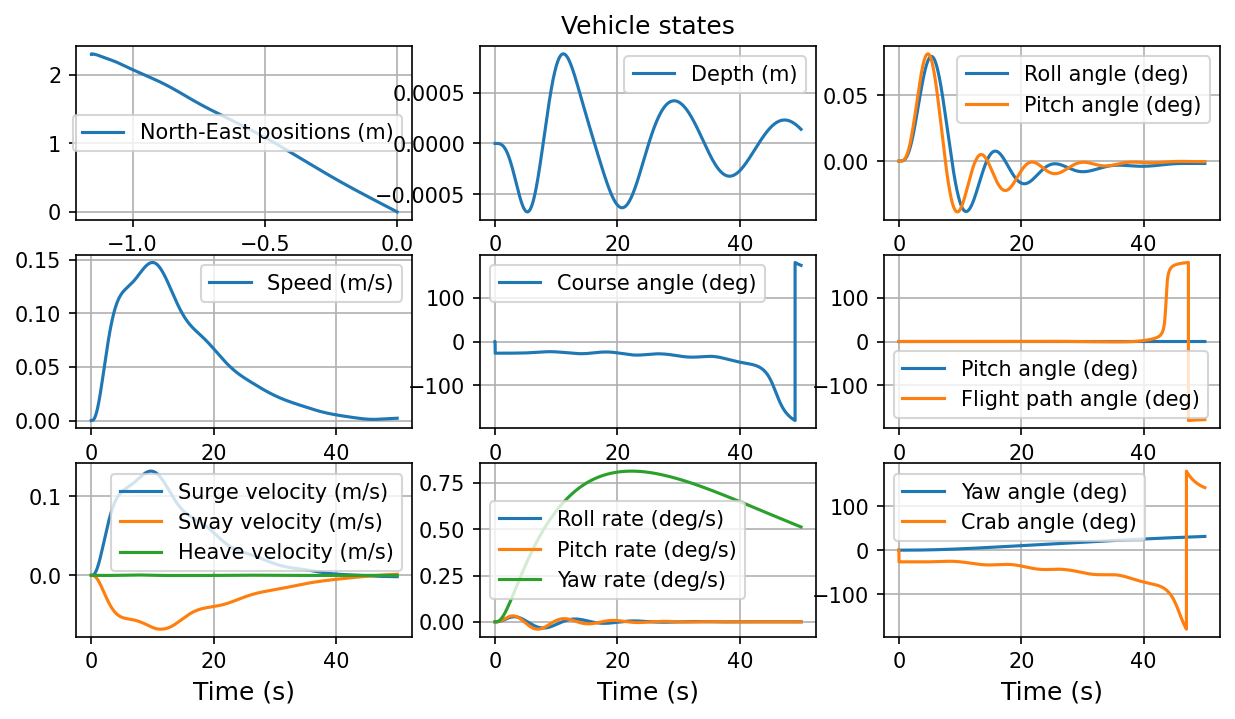

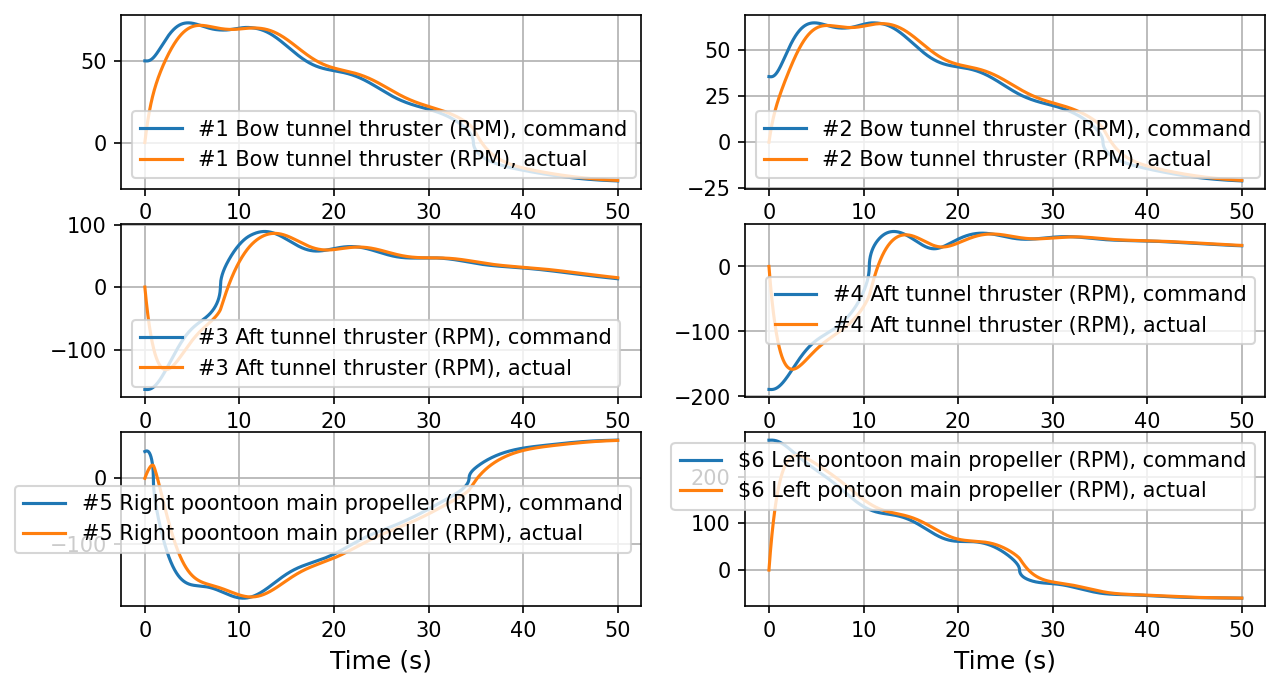

In [125]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [126]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

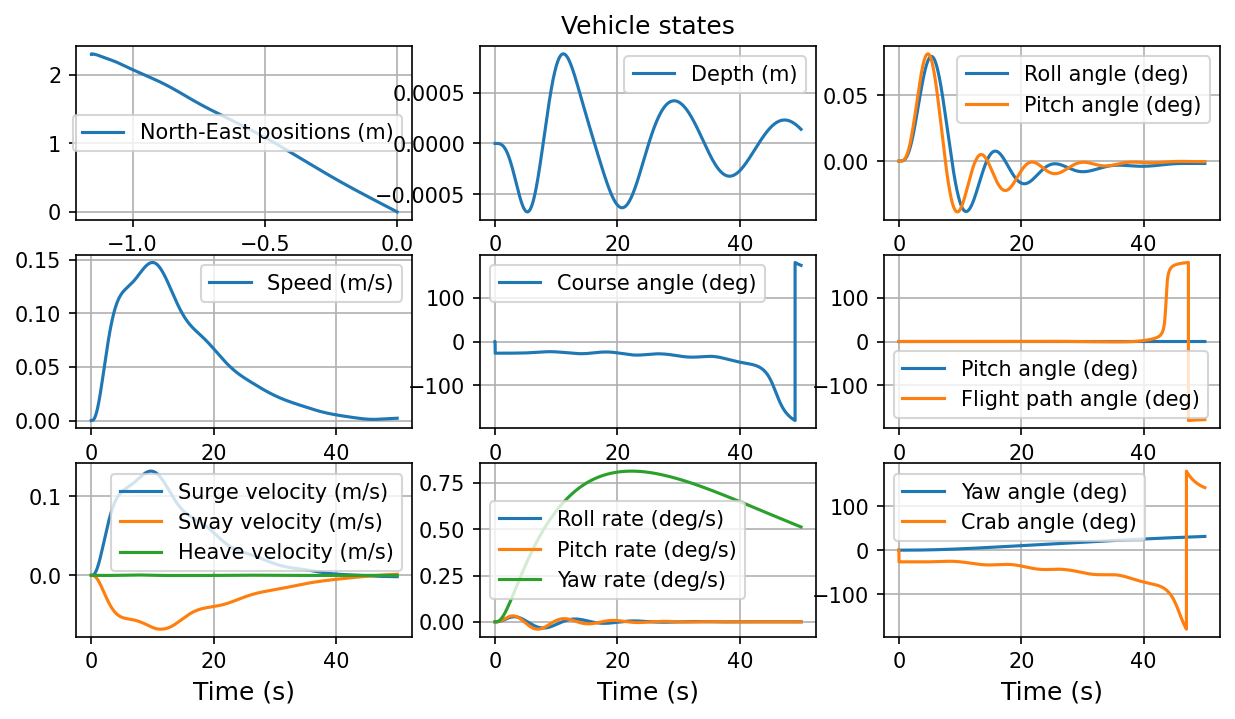

In [127]:
plotVehicleStates(simTime, simData, 3)

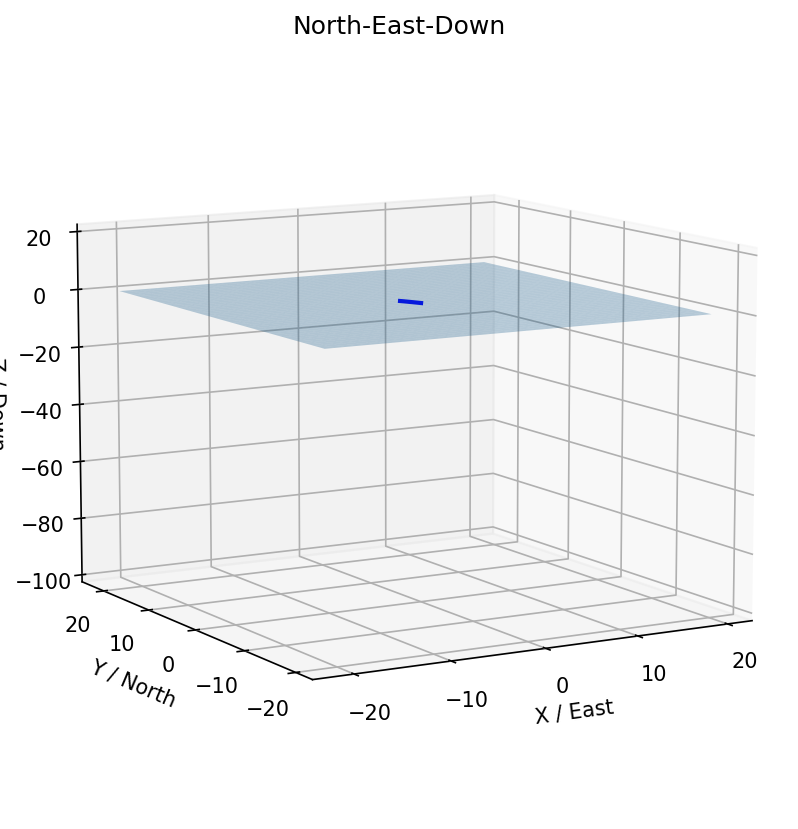

In [128]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [129]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [130]:
idx=1/0.01

In [131]:
idx

100.0

In [132]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [133]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [134]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [135]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [136]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [137]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(100)]
        self.wall_clock = datetime.now()

In [138]:
def grayscott1d(t, Q, coefs, T):
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]


#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])

#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])


#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]


#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]

#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve - T.v_m[1]
    vessel_movement[2] = -z_ve  - T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve  - T.v_m[4]
    vessel_movement[5] = psi_v- T.v_m[5]

    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = -z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v


    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
#         print(T.progression)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

#     T.v_m=np.copy(vessel_movement)

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [139]:
tspan = (0., 50)
T_ = MyTime()

In [140]:
coefs = [1, 1, 1, 1, 1, 1]

In [141]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
#             method='LSODA',
             t_eval=[i*sampleTime for i in range(int(tspan[-1]/(sampleTime)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_28056/2732499989.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  glob_force = fsolve(lambda x: np.linalg.inv(K)@x - np.array(vessel_movement) , np.zeros(len(vessel_movement)))


Physical time:  0.3462419251416382  Iteration wall clock time:  0:00:03.064209
Physical time:  1.0134436807642206  Iteration wall clock time:  0:00:20.377270
Physical time:  2.0881835783142666  Iteration wall clock time:  0:00:06.035540
Physical time:  3.6996402808555366  Iteration wall clock time:  0:00:07.220411
Physical time:  4.038994046407517  Iteration wall clock time:  0:00:02.386051
Physical time:  5.684954398225868  Iteration wall clock time:  0:00:04.660430
Physical time:  6.096444486180456  Iteration wall clock time:  0:00:02.286938
Physical time:  7.80053310093306  Iteration wall clock time:  0:00:04.916101
Physical time:  8.22655525462121  Iteration wall clock time:  0:00:02.675977
Physical time:  9.021084950797002  Iteration wall clock time:  0:00:03.999066
Physical time:  10.345301111089988  Iteration wall clock time:  0:00:01.395556
Physical time:  11.695364757195701  Iteration wall clock time:  0:00:18.300894
Physical time:  12.080788035259534  Iteration wall clock tim

### Results

In [142]:
fin=us

In [143]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-03 ...  5.000e+01  5.000e+01]
        y: [[ 0.000e+00 -4.743e-18 ...  1.588e-09  1.588e-09]
            [ 4.691e+01  4.691e+01 ...  4.691e+01  4.691e+01]
            ...
            [ 0.000e+00  6.943e-11 ... -3.570e-06 -3.567e-06]
            [ 0.000e+00  7.088e-11 ... -3.643e-06 -3.640e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 194
     njev: 0
      nlu: 0

In [144]:
t=fin.t

In [145]:
fin=fin.y.T

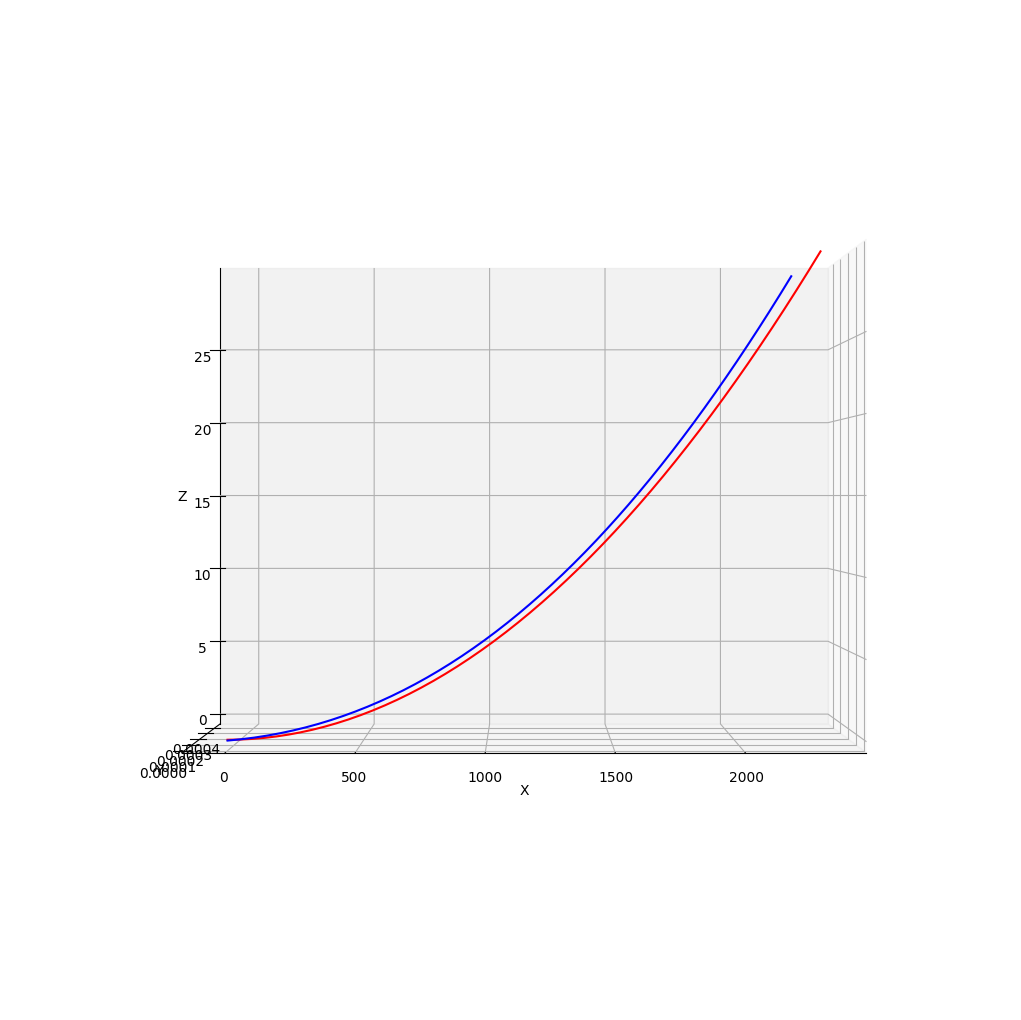

In [146]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [147]:
X,Y,Z

(array([1.58770424e-09, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
        1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
        3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955141e+02,
        5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
        7.50480205e+02, 7.97385218e+02, 8.44290231e+02, 8.91195244e+02,
        9.38100257e+02, 9.85005269e+02, 1.03191028e+03, 1.07881529e+03,
        1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
        1.31334036e+03, 1.36024537e+03, 1.40715038e+03, 1.45405540e+03,
        1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
        1.68858046e+03, 1.73548547e+03, 1.78239049e+03, 1.82929550e+03,
        1.87620051e+03, 1.92310552e+03, 1.97001054e+03, 2.01691555e+03,
        2.06382056e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
        2.25144061e+03, 2.29834563e+03]),
 array([-7.23354974e-12,  1.79903213e-05,  3.56115215e-05,  5.28633661e-05,
         6.9745617

In [148]:
X0,Y0,Z0

(array([   0.        ,   46.90501287,   93.81002573,  140.7150386 ,
         187.62005146,  234.52506433,  281.43007719,  328.33509006,
         375.24010292,  422.14511579,  469.05012866,  515.95514152,
         562.86015439,  609.76516725,  656.67018012,  703.57519298,
         750.48020585,  797.38521871,  844.29023158,  891.19524445,
         938.10025731,  985.00527018, 1031.91028304, 1078.81529591,
        1125.72030877, 1172.62532164, 1219.5303345 , 1266.43534737,
        1313.34036024, 1360.2453731 , 1407.15038597, 1454.05539883,
        1500.9604117 , 1547.86542456, 1594.77043743, 1641.67545029,
        1688.58046316, 1735.48547603, 1782.39048889, 1829.29550176,
        1876.20051462, 1923.10552749, 1970.01054035, 2016.91555322,
        2063.82056609, 2110.72557895, 2157.63059182, 2204.53560468,
        2251.44061755, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [149]:
us=fin.T

In [150]:
us.shape

(600, 50000)

In [151]:
12*50

600

In [152]:
us.T[:,4*node_N+49]

array([29.98978026, 29.98978026, 29.98978026, ..., 29.93884845,
       29.93884642, 29.93884439])

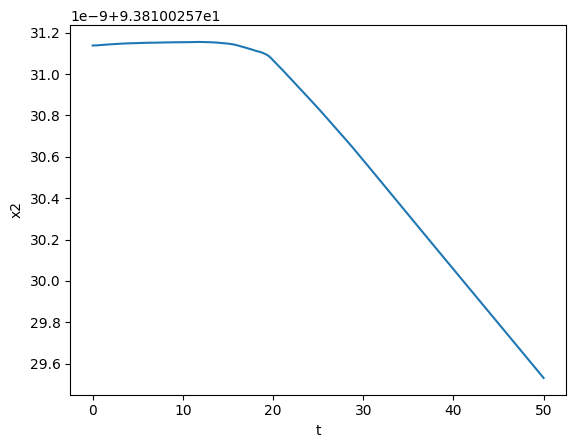

In [153]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

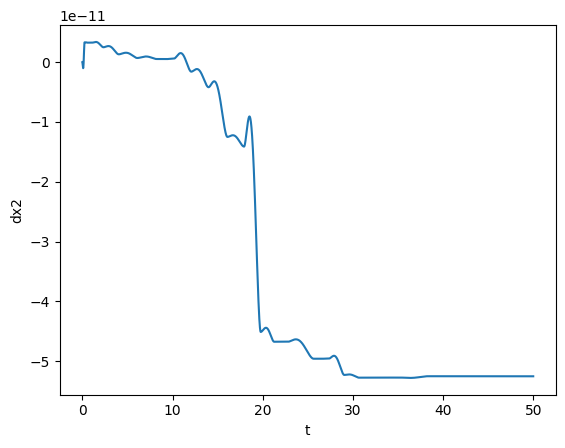

In [154]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

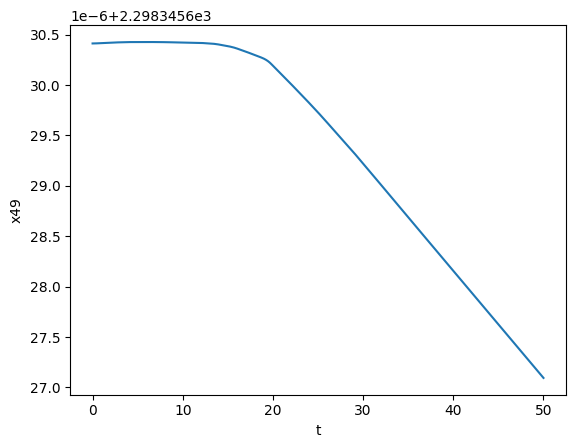

In [155]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

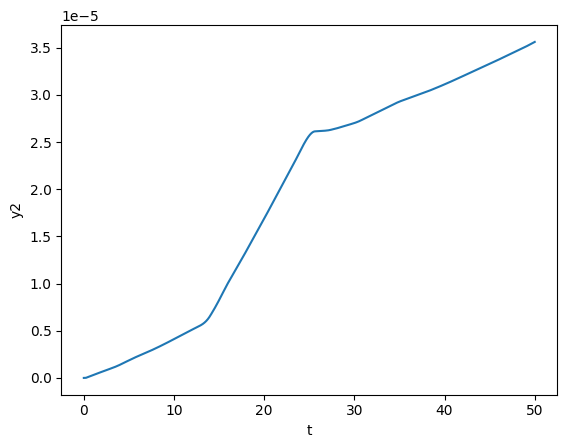

In [156]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

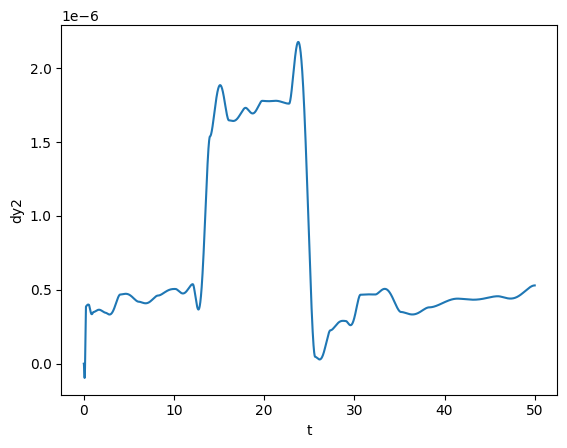

In [157]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

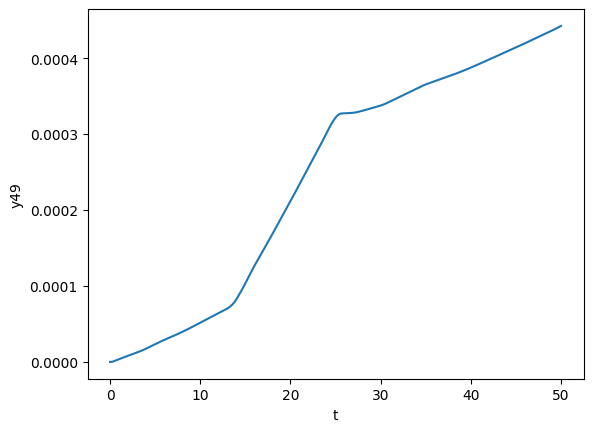

In [158]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

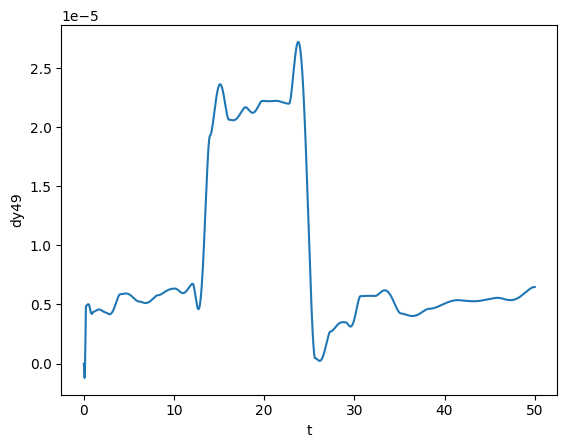

In [159]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

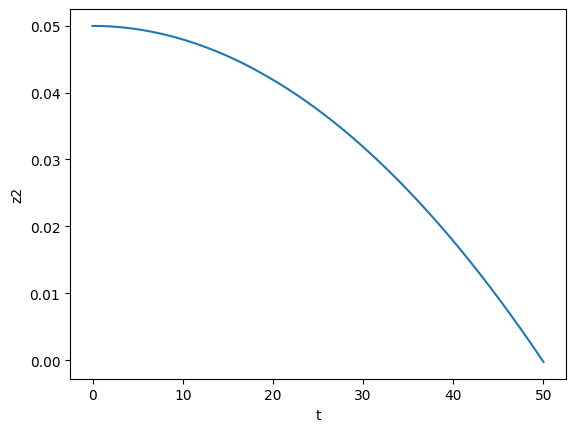

In [160]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

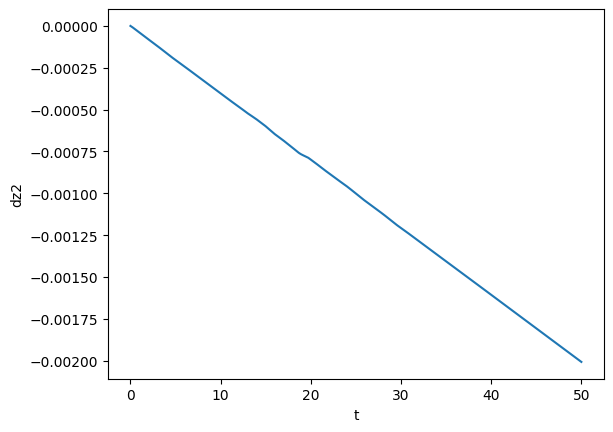

In [161]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

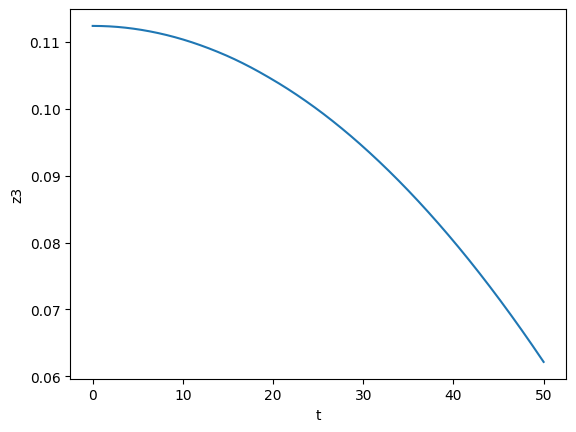

In [162]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

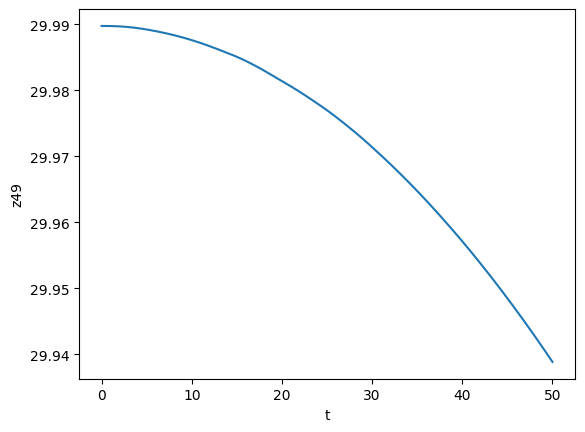

In [163]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

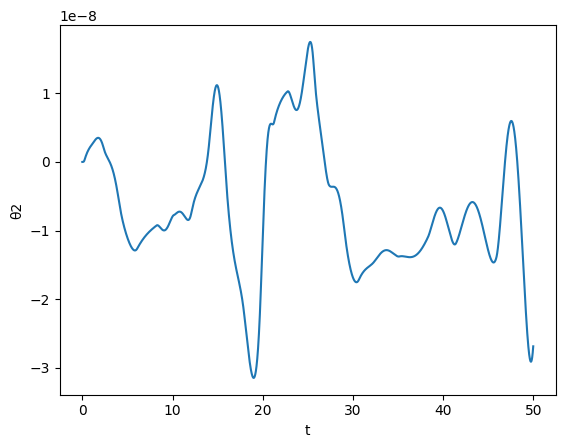

In [164]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

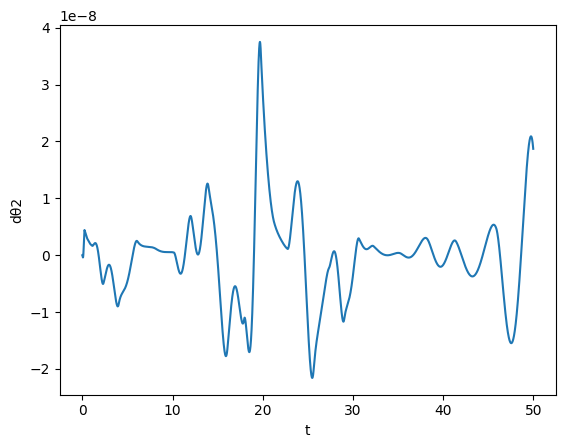

In [165]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

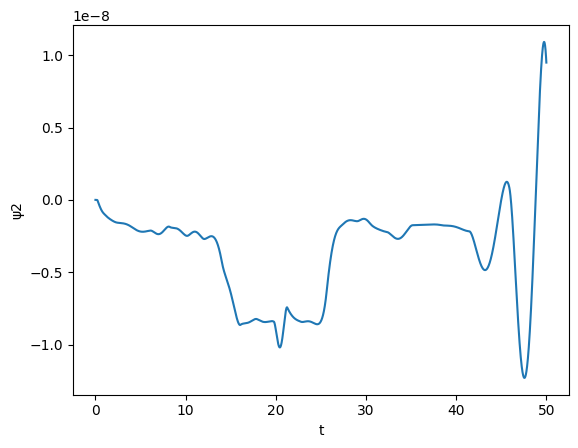

In [166]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

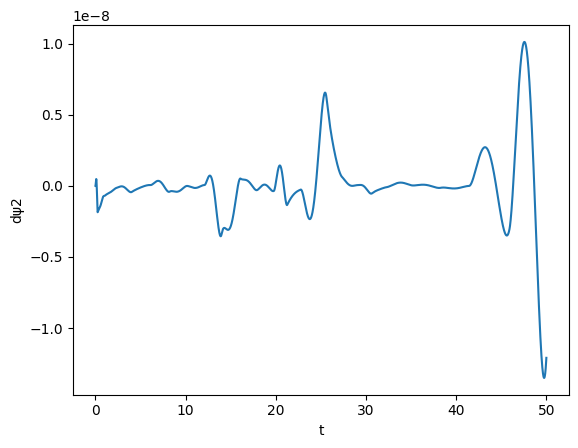

In [167]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

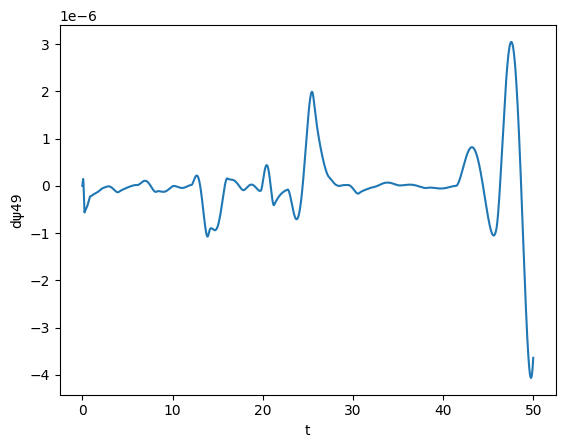

In [168]:
plt.plot(t,us.T[:,11*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dψ49')
plt.show()